# Facebook messenger statistics
Paste the path to a directory of a chat you'd like to analyze. It should contain 1 or more json files with names like 'message_1.json', 'message_2.json', etc.<br> The path should be enclosed with single or double quotes, and there should be an 'r' in front of the quotes, like this:<br>
PATH = _r'C:\mypath\mychat'<br>_
When that's ready you can click on Cell in the menu above and select 'Run All'

In [182]:
#%matplotlib inline
import stats_pandas as stats
import pandas as pd
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

#init_notebook_mode(connected=True)

PATH_TO_CHATS = r'C:\messenger-data\29.12.2022\facebook-100002163210723\messages\inbox'
PATH = stats.find_chat(PATH_TO_CHATS, 'friend')
chat = stats.load_from_path(PATH)

## General chat statistics

In [183]:
msg_stats_dict = stats.get_msg_stats(chat)
msg_stats = pd.DataFrame.from_dict(msg_stats_dict, columns = ['Total msgs sent', 'Avg msg length', 'Total chars sent'], orient = 'index')


col = 'Total msgs sent'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, text = col, labels = {'x': 'Sender'}, color = col,
           title = 'Total messages sent', color_continuous_scale = px.colors.sequential.RdPu)
f.update(layout_coloraxis_showscale=False)
#f.update_traces(textposition = 'outside')
f

In [184]:
col = 'Avg msg length'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, labels = {'x': 'Sender'}, text = col ,color = col,
           title = 'Average characters per message', color_continuous_scale = px.colors.sequential.Sunset)
f.update_traces(texttemplate='%{text:.1f}')
f.update(layout_coloraxis_showscale=False)
f

In [185]:
col = 'Total chars sent'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, labels = {'x': 'Sender'}, color = col, text = col,
           title = 'Total characters sent', color_continuous_scale = px.colors.sequential.PuBu)
f.update_traces(textposition = 'outside')
f.update(layout_coloraxis_showscale=False)
f

## Does average message length correlate with the number of messages sent?

In [186]:
fig = px.scatter(msg_stats, y = 'Avg msg length', x = 'Total msgs sent', trendline = 'ols', trendline_color_override = 'red')
fig.show()
cor = msg_stats.corr().iloc[0,1]
cor = msg_stats.corr().loc['Total msgs sent', 'Avg msg length']
print('The correlation is', cor)

The correlation is 0.532578243892016


## Who starts the most conversations?

In [187]:
from who_starts_conversations import count_conversation_starters

starters = count_conversation_starters(chat, mins_between_convos=180)
df = pd.DataFrame(starters.items())
df.columns = ['Person', 'Conversations Started']
df = df.sort_values(by='Conversations Started', ascending=False)
px.bar(df, y = 'Conversations Started', x = 'Person')

## Top 20 words most frequently used by each chat participant
You can change the minimal word lengths below

In [188]:
#change excluded words here:  excluded = ['example', 'example2']
excluded = ['example', 'example2']


#### change min_word_length here
min_word_length = 4


word_counts = stats.get_word_counts(chat, filter_participants_names = True, min_len = min_word_length, exclude_words = excluded)

In [189]:
plt_titles = [f'{sender} - min. word length = {min_word_length}' for sender in word_counts]
fig = make_subplots(
    rows=len(word_counts),
    cols=1,
    subplot_titles=plt_titles,
)
for i,sender in enumerate(word_counts):
    df = pd.DataFrame(word_counts[sender].items())[0:20]
    df.columns = ['word', 'count']
    f = px.bar(df, y = 'count', x = 'word', color = df.index)
    fig.add_trace(f.data[0], row = i + 1, col = 1)
fig.update_layout(height=len(word_counts) * 350, width=900)
fig.update(layout_coloraxis_showscale=False)
fig.show()

## Chat word cloud

In [190]:
word_counts = stats.get_word_counts(chat, False, None, 1) #get unfiltered word_counts


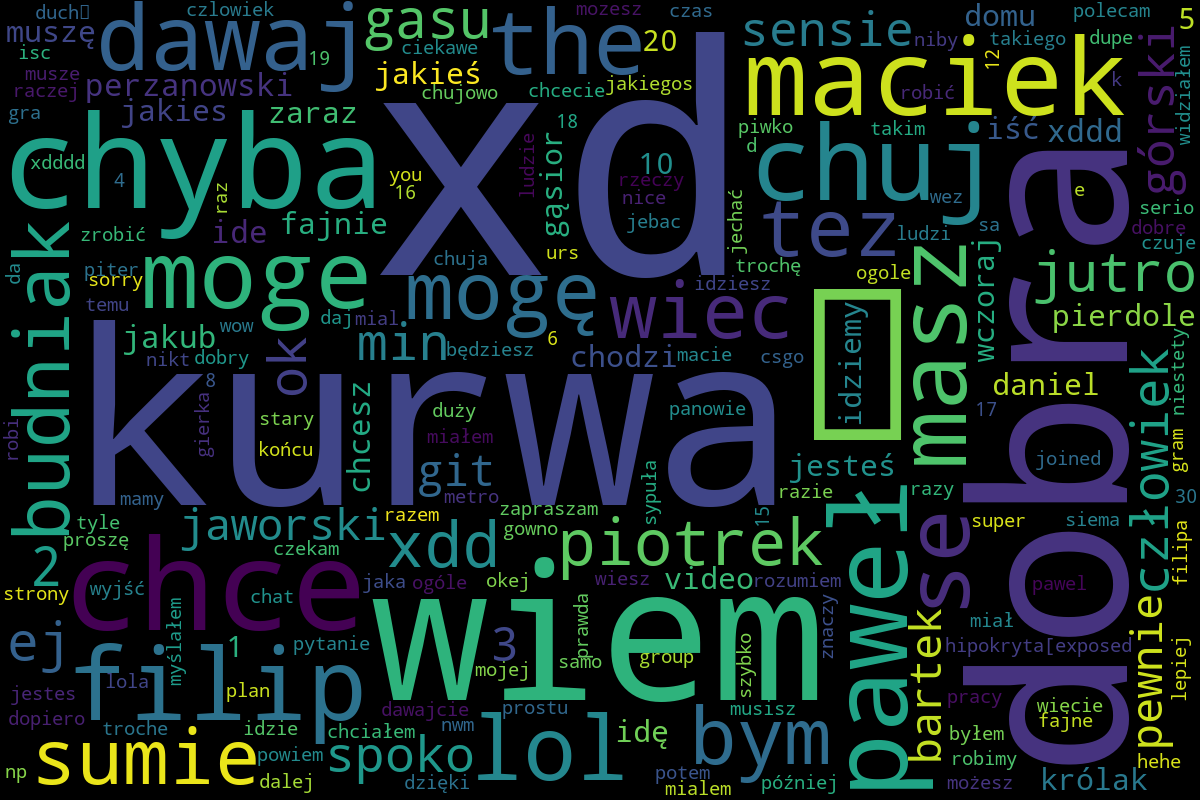

In [191]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

def get_total_word_counts(word_countds: dict) -> dict:
    '''
    Return total chat word counts without sender-wise separation.
    '''
    total_counts = Counter()
    for counts in word_counts.values():
        total_counts.update(Counter(counts))
        
    return total_counts

def show_img(img):
    fig = px.imshow(img)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    return fig

stopwords = set(stopwords.words('polish'))
total_counts = get_total_word_counts(word_counts) # word_counts['Paweł Budniak']
freqs = { k:v for k,v in total_counts.items() if k not in stopwords}

cloud = WordCloud(width = 1200, height = 800).generate_from_frequencies(freqs)
show_img(cloud)

## How often has _word1_ been used?
Set _word1_ below - it can be a single word, but also be a list of words.
If regex=True is specified, word1 can also be a re str pattern, or a list of re str patterns.

In [192]:



word1 = ['prosze', 'proszę'] ## set word1 here


#w1_coeffs = stats.get_kurwa_coefficients(word_counts_unfiltered, )
w1_coeffs = stats.word_usage_coefficients(word1, word_counts, msg_stats_dict, regex = False)
w1_coeffs = {k:v * 100 for k,v in sorted(w1_coeffs.items(), key = lambda item: item[1], reverse = True)}
w1_df = pd.DataFrame(w1_coeffs.items(), columns = ['Sender', f'{word1} per 100 msgs'])
fig = px.bar(w1_df, y = f'{word1} per 100 msgs', x = 'Sender')
fig.show()

## How often has every (polish) swear word been used?

In [193]:
pcoeffs = stats.get_profanity_coefficients(word_counts, msg_stats_dict, ignore_kurwas = False)

pcoeffs = {k:v * 100 for k,v  in sorted(pcoeffs.items(), key = lambda item: item[1], reverse = True)}
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
fig = px.bar(df, y = 'Profanity per 100 msgs', x = 'Sender')
fig.show()
df

,Sender,Profanity per 100 msgs
0,Kamil Bączek,8.510638
1,Maciek Górski,8.031672
2,Paweł Budniak,7.477197
3,Daniel Sypuła,6.477975
4,Filip Perzanowski,6.209077
5,Bartek Królak,6.103169
6,Jakub Gąsior,5.740023
7,Piotrek Jaworski,4.452037
8,Krzysiek Iwaniuk,3.274798
9,Marta Marcia Wisniewska,0.000000


## Correlation of _word1_ usage with (polish) swear word usage

In [194]:
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
df = df.merge(w1_df, how = 'inner')
cor = df.corr().iloc[0,1]
fig = px.scatter(df,y = 'Profanity per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is 0.4725514092449478


## Correlation of _word1_ (set above) usage with _word2_ (set below) usage

In [195]:

word2 = ['dziękuję', 'dziekuje'] # set word2 here



if word1 == word2:
    print('word 2 has to be different from word1')
w2_coeffs = stats.word_usage_coefficients(word2, word_counts, msg_stats_dict, regex = False)
w2_coeffs = {k:v * 100 for k,v in w2_coeffs.items()}
w2_df = pd.DataFrame(w2_coeffs.items(), columns = ['Sender', f'{word2} per 100 msgs'])

nat_join = w2_df.merge(w1_df, how = 'inner')
cor = nat_join.corr().iloc[0,1]
fig = px.scatter(nat_join,y = f'{word2} per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is 0.8543276794166755


## Types of messages sent

In [196]:
import math

# Set include_txt = True if the basic text message type should be included in the pie charts
msg_types = stats.get_msg_types(chat, include_txt = False)
ceiling = math.ceil(len(msg_types)/2)

fig = make_subplots(
    rows=ceiling,
    cols=2,
    subplot_titles=tuple(msg_types.keys()),
    specs =[[{'type':'domain'}]*2]*ceiling
)

for i,sender in enumerate(msg_types):
    mydf = pd.DataFrame.from_dict(msg_types[sender], orient = 'index', columns = ['count'])
    f = px.pie(mydf, values = 'count', names = mydf.index)
    fig.add_trace(f.data[0], row = math.ceil((i+1)/2), col = (i)%2+1)
fig.update_layout(height=500 * ceiling, width=900)
fig.show()

In [197]:
pd.DataFrame(stats.get_msg_types(chat, include_txt = True))

,Maciek Górski,Bartek Królak,Piotrek Jaworski,Paweł Budniak,Jakub Gąsior,Filip Perzanowski,Daniel Sypuła,Krzysiek Iwaniuk,Marta Marcia Wisniewska,Kamil Bączek
photos,4649,370.0,736,943,914.0,1575,422.0,165,NaN,23.0
videos,864,25.0,47,8,42.0,343,48.0,21,NaN,NaN
audio_files,138,2.0,5,1,7.0,42,5.0,2,NaN,NaN
gifs,134,2.0,2,5,95.0,72,NaN,4,NaN,NaN
files,13,NaN,4,2,NaN,1,NaN,1,NaN,NaN
sticker,118,6.0,36,12,69.0,110,3.0,75,NaN,16.0
share,718,33.0,113,191,187.0,223,51.0,51,NaN,7.0
txt,48005,11525.0,17863,17316,17965.0,42127,9557.0,1849,5.0,665.0


## Messages over time

In [198]:
dates = stats.groupby_date(chat, 'M')

f = px.line(dates, y = dates, x = dates.index, labels = {'y': 'Message count', 'x': 'Date'})
f.update_xaxes(nticks = 20, title ='Date')
f.show()

## Messages by time intervals

In [199]:
intervals = ['Y', 'M', 'W', 'H']
fullnames = {'Y': 'Year', 'M': 'Month', 'W': 'Weekday', 'H': 'Hour'}

plt_titles = [fullnames[i] for i in intervals]
fig = make_subplots(
    rows=len(intervals),
    cols=1,
    subplot_titles=plt_titles,
)

for i,interval in enumerate(intervals):
    series = stats.groupby_time(chat, interval, interval_names = True)
    
    f = px.bar(series, x = series.index, y = series, labels = {'x': fullnames[interval], 'y': 'Message count'})
    fig.add_trace(f.data[0], row = i + 1, col = 1)
fig.update_layout(height=len(intervals) * 500, bargap = 0.4)
#series = stats.groupby_time(chat, 'M', interval_names = True)
#px.bar(series, x = series.index, y = series, labels = {'x': fullnames[interval], 'y': 'Message count'})

## Total reactions used in the chat

In [200]:
from ipywidgets import interact, interactive, fixed, interact_manual

def plot_reactions(react_series, title = ''):
    total_reacts = react_series.sort_values(ascending = False)
    fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=('Flat values', 'Percentages'),
    #specs =[[, {'type':'domain'}]]
    specs = [[{'type': 'bar'}, {'type':'domain'}]]
    )
    f1 = px.bar(x=total_reacts.index, y=total_reacts)
    f2 = px.pie(values = total_reacts, names = total_reacts.index)
    f2.update_traces(textposition='inside', textinfo='percent+label')
    fig.add_trace(f1.data[0], row = 1, col = 1) 
    fig.add_trace(f2.data[0], row = 1, col = 2)
    fig.update_layout(title={'text': f'{title}'})
    return fig

def plot_reacts_received_controller(person, received_reacts):
    received_stats = received_reacts.loc[person].drop(['total', 'most_received'])
    return plot_reactions(received_stats, title=f'{person}\'s reactions received')

def plot_reacts_used_controller(person, used_reacts):
    used_stats = used_reacts.loc[person].drop(['total', 'most_used'])
    return plot_reactions(used_stats, title=f'{person}\'s reactions used')


plot_reactions(pd.Series(stats.total_reacts(chat)), title = 'Total reactions')

## Reactions used by each participant

In [201]:
used, received = stats.reaction_stats(chat)
interact(plot_reacts_used_controller, person=used.index, used_reacts=fixed(used))

interactive(children=(Dropdown(description='person', options=('Maciek Górski', 'Bartek Królak', 'Piotrek Jawor…

<function __main__.plot_reacts_used_controller(person, used_reacts)>

In [202]:
used

,👍,❤,😠,😆,😮,😢,👎,🤒,🤬,👌,...,🤓,1️⃣,🖕🏿,🕵🏿‍♂,😹,💬,🦈,🚔,total,most_used
Maciek Górski,219.0,363.0,26.0,21.0,37.0,40.0,136.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1034.0,❤
Bartek Królak,167.0,94.0,16.0,189.0,142.0,53.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751.0,😆
Piotrek Jaworski,185.0,157.0,22.0,168.0,97.0,156.0,55.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1026.0,👍
Paweł Budniak,189.0,25.0,32.0,49.0,109.0,44.0,64.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,590.0,👍
Jakub Gąsior,246.0,103.0,32.0,51.0,245.0,119.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1014.0,👍
Filip Perzanowski,204.0,147.0,39.0,116.0,95.0,123.0,85.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,918.0,👍
Daniel Sypuła,79.0,6.0,13.0,138.0,89.0,56.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462.0,😆
Krzysiek Iwaniuk,26.0,0.0,1.0,20.0,4.0,8.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,👍
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍


## Reactions received by each participant

In [203]:
interact(plot_reacts_received_controller, person=received.index, received_reacts=fixed(received))

interactive(children=(Dropdown(description='person', options=('Maciek Górski', 'Bartek Królak', 'Piotrek Jawor…

<function __main__.plot_reacts_received_controller(person, received_reacts)>

In [204]:
received

,❤,😆,👍,🤮,😢,👍🏿,😮,👎🏿,😠,🙏,...,🚒,💦,🥴,⌨️,🖕🏿,👾,👨‍🦽,🦈,total,most_received
Maciek Górski,257.0,245.0,282.0,1.0,158.0,1.0,207.0,7.0,52.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1505.0,👍
Bartek Królak,86.0,37.0,51.0,0.0,29.0,1.0,59.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344.0,❤
Piotrek Jaworski,147.0,71.0,169.0,0.0,68.0,0.0,106.0,5.0,19.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,745.0,👍
Paweł Budniak,74.0,142.0,217.0,0.0,59.0,1.0,104.0,1.0,32.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,810.0,👍
Jakub Gąsior,173.0,128.0,245.0,0.0,109.0,2.0,100.0,1.0,30.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1011.0,👍
Filip Perzanowski,157.0,99.0,267.0,0.0,141.0,0.0,185.0,8.0,33.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1138.0,👍
Daniel Sypuła,1.0,26.0,78.0,0.0,33.0,0.0,47.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.0,👍
Krzysiek Iwaniuk,0.0,4.0,6.0,0.0,2.0,0.0,10.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,😮
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,❤
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,❤


## Ratio of each reaction received to total messages sent by each person

In [205]:
percents = stats.react_percents(received, msg_stats_dict)
percents

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



,❤,😆,👍,🤮,😢,👍🏿,😮,👎🏿,😠,🙏,...,🚒,💦,🥴,⌨️,🖕🏿,👾,👨‍🦽,🦈,total,most_received
Maciek Górski,0.48%,0.46%,0.53%,0.00%,0.29%,0.00%,0.39%,0.01%,0.10%,0.02%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.80%,👍
Bartek Królak,0.72%,0.31%,0.43%,0.00%,0.24%,0.01%,0.49%,0.03%,0.03%,0.02%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.88%,❤
Piotrek Jaworski,0.78%,0.38%,0.90%,0.00%,0.36%,0.00%,0.57%,0.03%,0.10%,0.06%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,3.98%,👍
Paweł Budniak,0.40%,0.78%,1.19%,0.00%,0.32%,0.01%,0.57%,0.01%,0.17%,0.02%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,4.42%,👍
Jakub Gąsior,0.91%,0.67%,1.28%,0.00%,0.57%,0.01%,0.52%,0.01%,0.16%,0.07%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,5.29%,👍
Filip Perzanowski,0.35%,0.22%,0.60%,0.00%,0.32%,0.00%,0.42%,0.02%,0.07%,0.01%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.57%,👍
Daniel Sypuła,0.01%,0.26%,0.78%,0.00%,0.33%,0.00%,0.47%,0.00%,0.10%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.92%,👍
Krzysiek Iwaniuk,0.00%,0.19%,0.28%,0.00%,0.09%,0.00%,0.47%,0.00%,0.09%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.57%,😮
Marta Marcia Wisniewska,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,❤
Kamil Bączek,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,❤


## People who receive the most reactions

In [206]:
titles = [ ('funniest', '😆'), ('most hated','👎'), ('most infuriating', '😠'),
           ('most beloved', '😍'), ('most shocking', '😮'), ('saddest', '😢'), ('most liked', '👍'), ('beloved v3', '💗'), ('beloved v2', '❤')]

for title, emoji in titles:
    stats.most_reactions(received, title, emoji, percent = False)

The funniest person is Maciek Górski: 245.0 of his messages received '😆', 2nd place: Paweł Budniak (142.0)

The most hated person is Paweł Budniak: 95.0 of his messages received '👎', 2nd place: Filip Perzanowski (85.0)

The most infuriating person is Maciek Górski: 52.0 of his messages received '😠', 2nd place: Filip Perzanowski (33.0)

The most beloved person is Maciek Górski: 179.0 of his messages received '😍', 2nd place: Jakub Gąsior (146.0)

The most shocking person is Maciek Górski: 207.0 of his messages received '😮', 2nd place: Filip Perzanowski (185.0)

The saddest person is Maciek Górski: 158.0 of his messages received '😢', 2nd place: Filip Perzanowski (141.0)

The most liked person is Maciek Górski: 282.0 of his messages received '👍', 2nd place: Filip Perzanowski (267.0)

The beloved v3 person is Maciek Górski: 5.0 of his messages received '💗', 2nd place: Filip Perzanowski (4.0)

The beloved v2 person is Maciek Górski: 257.0 of his messages received '❤', 2nd place: Jakub Gąsior

## People who receive the most reactions relative to the number of messages they send

In [207]:
for title, emoji in titles:
    stats.most_reactions(percents, title, emoji, percent = True)

The funniest person is Paweł Budniak: 0.78% of his messages received '😆', 2nd place: Jakub Gąsior (0.67%)

The most hated person is Paweł Budniak: 0.52% of his messages received '👎', 2nd place: Daniel Sypuła (0.43%)

The most infuriating person is Paweł Budniak: 0.17% of his messages received '😠', 2nd place: Jakub Gąsior (0.16%)

The most beloved person is Jakub Gąsior: 0.76% of his messages received '😍', 2nd place: Daniel Sypuła (0.55%)

The most shocking person is Piotrek Jaworski: 0.57% of his messages received '😮', 2nd place: Paweł Budniak (0.57%)

The saddest person is Jakub Gąsior: 0.57% of his messages received '😢', 2nd place: Piotrek Jaworski (0.36%)

The most liked person is Jakub Gąsior: 1.28% of his messages received '👍', 2nd place: Paweł Budniak (1.19%)

The beloved v3 person is Bartek Królak: 0.02% of his messages received '💗', 2nd place: Maciek Górski (0.01%)

The beloved v2 person is Jakub Gąsior: 0.91% of his messages received '❤', 2nd place: Piotrek Jaworski (0.78%)



## Messages that received the biggest number of each reaction

In [208]:
stats.print_reaction_records(chat, PATH)

👍:6, sender: Jakub Gąsior  2020-06-07 20:01:39.096000
content:  Kto nie idzie jutro do szkoły łapka w górę 

👎:6, sender: Piotrek Jaworski  2020-05-28 15:04:45.043000
content:  Chce ktoś na pójść na jakieś wpierdalanie? 

😆:4, sender: Paweł Budniak  2018-12-13 08:28:18.574000
C:\messenger-data\29.12.2022\facebook-100002163210723\messages\inbox\wherearemyfriends_1036271813080582\photos\48396105_221286398762281_3447868521093005312_n_221286368762284.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\messenger-data\\29.12.2022\\facebook-100002163210723\\messages\\inbox\\wherearemyfriends_1036271813080582\\photos\\48396105_221286398762281_3447868521093005312_n_221286368762284.jpg'

## Messages with most reactions received + context

In [209]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [210]:
top_n = 3 # top n messages
context_msgs = 2 # 
reaction_emoji = stats.emojis['LIKE_EMOJI'] # pick react type from keys displayed above

interact(stats.most_reacted_msgs, react=stats.emojis.values(), 
        how_many=(0,10), context=(0,10),
        chat_path=fixed(PATH), chat_df = fixed(chat))

interactive(children=(Dropdown(description='react', options=('👍', '👎', '😆', '❤', '😍', '😮', '😠', '😢', '💗'), val…

<function stats_pandas.most_reacted_msgs(chat_df, chat_path, react, how_many=3, context=2)>